In [2]:
import tensorflow as tf
from model.dataset import Dataset
#from model.fp.melspec.melspectrogram import get_melspec_layer
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.nnfp import get_fingerprinter
from model.fp.NTxent_loss_single_gpu import NTxentLoss
from model.fp.online_triplet_loss import OnlineTripletLoss
from model.fp.lamb_optimizer import LAMB
from model.utils.experiment_helper import ExperimentHelper

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda, Permute
from kapre.time_frequency import Magnitude #STFT, #, ApplyFilterbank
import math

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

from kapre import backend
from kapre.backend import _CH_FIRST_STR, _CH_LAST_STR, _CH_DEFAULT_STR

In [5]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import tensor_util
import numpy as np
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.ops.signal import window_ops
from tensorflow.python.ops.signal import shape_ops
from tensorflow.python.ops.signal import fft_ops
from tensorflow.python.util import dispatch

In [6]:
def _enclosing_power_of_two(value):
  """Return 2**N for integer N such that 2**N >= value."""
  value_static = tensor_util.constant_value(value)
  if value_static is not None:
    return constant_op.constant(
        int(2**np.ceil(np.log(value_static) / np.log(2.0))), value.dtype)
  return math_ops.cast(
      math_ops.pow(
          2.0,
          math_ops.ceil(
              math_ops.log(math_ops.cast(value, dtypes.float32)) /
              math_ops.log(2.0))), value.dtype)

In [7]:
@dispatch.add_dispatch_support
def stft(signals, frame_length, frame_step, fft_length=None,
         window_fn=window_ops.hann_window,
         pad_end=False, name=None):
  with ops.name_scope(name, 'stft', [signals, frame_length,
                                     frame_step]):
    #tf.print(f"window_fn:{window_fn}")
    signals = ops.convert_to_tensor(signals, name='signals')
    signals.shape.with_rank_at_least(1)
    frame_length = ops.convert_to_tensor(frame_length, name='frame_length')
    frame_length.shape.assert_has_rank(0)
    frame_step = ops.convert_to_tensor(frame_step, name='frame_step')
    frame_step.shape.assert_has_rank(0)

    tf.print(f"frame_length:{frame_length}")

    if fft_length is None:
      fft_length = _enclosing_power_of_two(frame_length)
    else:
      fft_length = ops.convert_to_tensor(fft_length, name='fft_length')

    tf.print(f"fft_length:{fft_length}")

    framed_signals = shape_ops.frame(
        signals, frame_length, frame_step, pad_end=pad_end)
    
    #tf.print(f"framed_signals{framed_signals}")#ver uns tf.prints aqui

    # Optionally window the framed signals.
    if window_fn is not None:
      window = window_fn(frame_length, dtype=framed_signals.dtype)
      framed_signals *= window
      #tf.print(f"window{window}")
      #tf.print(f"framed_signals{framed_signals}")

    #tf.print(f"rfft{fft_ops.rfft(framed_signals, [fft_length])}")
    # fft_ops.rfft produces the (fft_length/2 + 1) unique components of the
    # FFT of the real windowed signals in framed_signals.
    return fft_ops.rfft(framed_signals, [fft_length])

In [8]:
class STFT(Layer):
    def __init__(
        self,
        n_fft=2048,
        win_length=None,
        hop_length=None,
        window_name=None,
        pad_begin=False,
        pad_end=False,
        input_data_format='default',
        output_data_format='default',
        **kwargs,
    ):
        super(STFT, self).__init__(**kwargs)

        backend.validate_data_format_str(input_data_format)
        backend.validate_data_format_str(output_data_format)

        if win_length is None:
            win_length = n_fft
        if hop_length is None:
            hop_length = win_length // 4

        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.window_name = window_name
        self.window_fn = backend.get_window_fn(window_name)
        self.pad_begin = pad_begin
        self.pad_end = pad_end

        idt, odt = input_data_format, output_data_format
        self.output_data_format = K.image_data_format() if odt == _CH_DEFAULT_STR else odt
        self.input_data_format = K.image_data_format() if idt == _CH_DEFAULT_STR else idt

    def call(self, x):
        #tf.print(f"x{x.shape, type(x), x}")
        waveforms = x  # (batch, ch, time) if input_data_format == 'channels_first'.
        # (batch, time, ch) if input_data_format == 'channels_last'.

        # this is needed because tf.signal.stft lives in channels_first land.
        if self.input_data_format == _CH_LAST_STR:
            waveforms = tf.transpose(
                waveforms, perm=(0, 2, 1)
            )  # always (batch, ch, time) from here

        if self.pad_begin:
            waveforms = tf.pad(
                waveforms, tf.constant([[0, 0], [0, 0], [int(self.n_fft - self.hop_length), 0]])
            )
        #tf.print(f"self.pad_begin={self.pad_begin}, self.input_data_format={self.input_data_format}")
        #tf.print(f"waveforms{waveforms.shape, type(waveforms), waveforms}")
        
        #tf.print(f"self.window_fn{self.window_fn}")
        stfts = stft(
            signals=waveforms,
            frame_length=self.win_length,
            frame_step=self.hop_length,
            fft_length=self.n_fft,
            window_fn=self.window_fn,
            pad_end=self.pad_end,
            name='%s_tf.signal.stft' % self.name,
        )  # (batch, ch, time, freq)
        
        #tf.print(f"stfts{stfts}")

        if self.output_data_format == _CH_LAST_STR:
            stfts = tf.transpose(stfts, perm=(0, 2, 3, 1))  # (batch, t, f, ch)

        #tf.print(f"self.output_data_format={self.output_data_format}")
        #tf.print(f"stfts{stfts.shape, type(stfts), stfts}")
        return stfts

    def get_config(self):
        config = super(STFT, self).get_config()
        config.update(
            {
                'n_fft': self.n_fft,
                'win_length': self.win_length,
                'hop_length': self.hop_length,
                'window_name': self.window_name,
                'pad_begin': self.pad_begin,
                'pad_end': self.pad_end,
                'input_data_format': self.input_data_format,
                'output_data_format': self.output_data_format,
            }
        )
        return config

In [9]:
import math
import librosa
%matplotlib widget
import matplotlib.pyplot as plt

In [10]:
from kapre.time_frequency import ApplyFilterbank

class CustomApplyFilterbank(ApplyFilterbank):
    def __init__(self, type, filterbank_kwargs, data_format='default', **kwargs):
        super(CustomApplyFilterbank, self).__init__(type, filterbank_kwargs, data_format, **kwargs)

        # tipo de Banco de filtros
        if type == 'tri':
            self.filterbank = self.filterbank_triangular_log(**filterbank_kwargs)

        if data_format == _CH_DEFAULT_STR:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

        if self.data_format == _CH_FIRST_STR:
            self.freq_axis = 3
        else:
            self.freq_axis = 2

    def filterbank_triangular_log(self, sample_rate, n_fft):
        # Com o objetivo de ter 256 filtros e 8000 Hz na frequência de amostragem, teve-se de optar por Nfft de 2048, o que resulta em 54.4024 filtros por oitava, e numa frequência mínima de 151.3483 Hz.

        # Sendo assim, o Nfpo será 60, 5*12, e a frequência do último filtro, f256, será Si7 = 3951.066410048992 Hz. Resultando numa frequência máxima de 3996.975590329487 Hz.
        # Com isto, obtem-se pelo menos um bin em cada filtro, visto que f0*(2^(2/Nfpo)-1) = 4.7979 > 8000/2048 = 3.9062. Para uma Nfft de 1024, não era certo que obtivesse pelo menos um bin por filtro.
        #O primeiro filtro estava a zero.

        n_fft=2048
        sample_rate=8000
        Nfpo=60 #=5*12
        Nb =256

        #Cálculo da fmin e fmax
        f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
        f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
        fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

        #Depois disto, dá bins em todos os fitros. Ver a linha 24 do getOctaveFilterBanck2.m

        i=np.arange(1,Nb+1, dtype=float)
        k=np.arange(n_fft//2+1)
        f=k*sample_rate/n_fft

        fcf = f0 * 2.**(i/Nfpo) #3905.68454168

        fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 

        # Construct the output matrix
        H = np.zeros((Nb, n_fft // 2 + 1))

        #for i in range(n_filters), com isto são 256
        for j in range(Nb):
            fLow = fi[j] 
            fmid = fi[j+1] 
            fUpp = fi[j+2]

            H[j, :] = ((f - fLow) / (fmid - fLow)) * ((f > fLow) & (f <= fmid)) + \
                            ((f - fUpp) / (fmid - fUpp)) * ((f > fmid) & (f <= fUpp))
            

        #H /= np.sum(H, axis=1, keepdims=True) # : A matriz é normalizada ao longo do eixo 1 (linhas), dividindo cada valor pela soma dos valores na respectiva linha. Isto garante que a soma de cada linha seja igual a 1.65
        
        #Ver os filtros
        """
        plt.figure(figsize=(10, 6))
        for j in range(Nb):
            plt.plot(f, H[j, :])
        plt.title('Triangular Log Filterbank')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
        """
        return tf.convert_to_tensor(H.T, dtype=tf.float32)
        #return tf.convert_to_tensor(H.T)
    

    def call(self, x):
        #tf.print(f"self.filterbank_shape={self.filterbank.shape}")
        output = tf.tensordot(x, self.filterbank, axes=(self.freq_axis, 0))
                
        if self.data_format == _CH_LAST_STR:
            output = tf.transpose(output, (0, 1, 3, 2))
        return output

In [11]:
1e-2

0.01

In [12]:
class MagnitudeSquared(Layer):
    def call(self, x):
        return tf.abs(x)**2

In [13]:
class Melspec_layer(Model):
    """
    A wrapper class, based on the implementation:
        https://github.com/keunwoochoi/kapre
        
    Input:
        (B,1,T)
    Output:
        (B,C,T,1) with C=Number of mel-bins
    
    USAGE:
        
        See get_melspec_layer() in the below.
        
    """
    def __init__(
            self,
            input_shape=(1, 8000),
            segment_norm=False,
            n_fft=2048,
            stft_hop=192,
            n_mels=256,
            fs=8000,
            dur=1.,
            f_min=300,
            f_max=4000.,
            amin=10e-2, # minimum amp.
            dynamic_range=80.,
            use_pad_layer=False,
            name='Mel-spectrogram',
            trainable=False,
            **kwargs
            ):
        super(Melspec_layer, self).__init__(name=name, trainable=False, **kwargs)
        
        self.mel_fb_kwargs = {
            'sample_rate': fs,
            'n_freq': n_fft // 2 + 1,
            'n_mels': n_mels,
            'f_min': f_min,
            'f_max': f_max,
            }
        
        self.tri_fb_kwargs = {
            'sample_rate': fs,
            'n_fft': n_fft,
            }
            
        self.n_fft = n_fft
        self.stft_hop = stft_hop
        self.n_mels = n_mels
        self.amin = amin
        self.dynamic_range = dynamic_range
        self.segment_norm = segment_norm

         # 'SAME' Padding layer
        self.use_pad_layer = use_pad_layer
        self.pad_l = n_fft // 2
        self.pad_r = n_fft // 2
        self.padded_input_shape = (1, int(fs * dur) + self.pad_l + self.pad_r)
        self.pad_layer = Lambda(
            lambda z: tf.pad(z, tf.constant([[0, 0], [0, 0],
                                             [self.pad_l, self.pad_r]]))
            )
        
        # Construct log-power Mel-spec layer
        self.m = self.construct_melspec_layer(input_shape, name)

        # Permute layer
        self.p = tf.keras.Sequential(name='Permute')
        self.p.add(Permute((3, 2, 1), input_shape=self.m.output_shape[1:]))
        
        super(Melspec_layer, self).build((None, input_shape[0], input_shape[1]))
        
        
    def construct_melspec_layer(self, input_shape, name):
        m = tf.keras.Sequential(name=name)
        m.add(tf.keras.layers.InputLayer(input_shape=input_shape))
        if self.use_pad_layer:
            m.add(self.pad_layer)
        m.add(
            STFT(
                n_fft=self.n_fft,
                hop_length=self.stft_hop,
                window_name='hamming_window',
                pad_begin=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                pad_end=False, # We do not use Kapre's padding, due to the @tf.function compatiability
                input_data_format='channels_first',
                output_data_format='channels_first')
            )
        m.add(
            MagnitudeSquared()
            )
        m.add(
            CustomApplyFilterbank(type='tri',
                            filterbank_kwargs=self.tri_fb_kwargs,
                            data_format='channels_first'
                            )
            )
        return m
        

    @tf.function
    def call(self, x):
        x = self.m(x) + 0.06
        #x = tf.sqrt(x)
        
        #tf.print(f"x={x, type(x), x.shape}")
        #tf.print(f"maximo={tf.maximum(x, self.amin)}")
        #tf.print(f"x_contas={tf.math.log(tf.maximum(x, self.amin)) / math.log(10)}")
        
        x = tf.math.log(tf.maximum(x, self.amin)) / math.log(10) # ver se usa o 20 aqui, com 20 ficava em db, sem 20 não
        
        #tf.print(f"x do log={x}")
        
        x = x - tf.reduce_max(x)
        x = tf.maximum(x, -1 * self.dynamic_range) #ver os dados do x aqui
        if self.segment_norm:
            x = (x - tf.reduce_min(x) / 2) / tf.abs(tf.reduce_min(x) / 2 + 1e-10)
        return self.p(x) # Permute((3,2,1))
    

def get_melspec_layer(cfg, trainable=False):
    #type - 'mel' filter bank
    """fs = cfg['MODEL']['FS']
    dur = cfg['MODEL']['DUR']
    n_fft = cfg['MODEL']['STFT_WIN']
    stft_hop = cfg['MODEL']['STFT_HOP']
    n_mels = cfg['MODEL']['N_MELS']
    f_min = cfg['MODEL']['F_MIN']
    f_max = cfg['MODEL']['F_MAX']
    if cfg['MODEL']['FEAT'] == 'melspec':
        segment_norm = False
    elif cfg['MODEL']['FEAT'] == 'melspec_maxnorm':
        segment_norm = True
    else:
        raise NotImplementedError(cfg['MODEL']['FEAT'])
    use_pad_layer = True"""

    #type - 'tri' filter bank
    fs = cfg['MODEL']['FS']
    dur = cfg['MODEL']['DUR']
    n_fft = cfg['MODEL']['STFT_WIN']
    stft_hop = cfg['MODEL']['STFT_HOP']
    n_mels = cfg['MODEL']['N_MELS']
    f_min = cfg['MODEL']['F_MIN']
    f_max = cfg['MODEL']['F_MAX']
    if cfg['MODEL']['FEAT'] == 'melspec':
        segment_norm = False
    elif cfg['MODEL']['FEAT'] == 'melspec_maxnorm':
        segment_norm = True
    else:
        raise NotImplementedError(cfg['MODEL']['FEAT'])
    use_pad_layer = False
    
    input_shape = (1, int(fs * dur))
    l = Melspec_layer(input_shape=input_shape,
                      segment_norm=segment_norm,
                      n_fft=n_fft,
                      stft_hop=stft_hop,
                      n_mels=n_mels,
                      fs=fs,
                      dur=dur,
                      f_min=f_min,
                      f_max=f_max,
                      use_pad_layer=use_pad_layer)
    l.trainable = trainable
    return l

In [14]:
def build_fp(cfg):
    """ Build fingerprinter """
    # m_pre: log-power-Mel-spectrogram layer, S.
    m_pre = get_melspec_layer(cfg, trainable=False)

    # m_specaug: spec-augmentation layer.
    m_specaug = get_specaug_chain_layer(cfg, trainable=False)
    assert(m_specaug.bypass==False) # Detachable by setting m_specaug.bypass.

    # m_fp: fingerprinter g(f(.)).
    m_fp = get_fingerprinter(cfg, trainable=False)
    return m_pre, m_specaug, m_fp

In [15]:
import os
import sys
import pathlib
import click
import yaml
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_config(config_fname):
    config_filepath = './config/' + config_fname + '.yaml'
    if os.path.exists(config_filepath):
        print(f'cli: Configuration from {config_filepath}')
    else:
        sys.exit(f'cli: ERROR! Configuration file {config_filepath} is missing!!')

    with open(config_filepath, 'r') as f:
        cfg = yaml.safe_load(f)
    return cfg

In [16]:
config = "default_RA"
cfg = load_config(config)
checkpoint_name = "Checks"

cli: Configuration from ./config/default_RA.yaml


In [17]:
# Dataloader
dataset = Dataset(cfg)

# Build models.
m_pre, m_specaug, m_fp = build_fp(cfg)

# Learning schedule
total_nsteps = cfg['TRAIN']['MAX_EPOCH'] * len(dataset.get_train_ds())
if cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS':
    lr_schedule = tf.keras.experimental.CosineDecay(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        decay_steps=total_nsteps,
        alpha=1e-06)
elif cfg['TRAIN']['LR_SCHEDULE'].upper() == 'COS-RESTART':
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=float(cfg['TRAIN']['LR']),
        first_decay_steps=int(total_nsteps * 0.1),
        num_periods=0.5,
        alpha=2e-06)
else:
    lr_schedule = float(cfg['TRAIN']['LR'])

# Optimizer
if cfg['TRAIN']['OPTIMIZER'].upper() == 'LAMB':
    opt = LAMB(learning_rate=lr_schedule)
elif cfg['TRAIN']['OPTIMIZER'].upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    raise NotImplementedError(cfg['TRAIN']['OPTIMIZER'])

# Experiment helper: see utils.experiment_helper.py for details.
helper = ExperimentHelper(
    checkpoint_name=checkpoint_name,
    optimizer=opt,
    model_to_checkpoint=m_fp,
    cfg=cfg)

# Loss objects
if cfg['LOSS']['LOSS_MODE'].upper() == 'NTXENT': # Default
    loss_obj_train = NTxentLoss(
        n_org=cfg['BSZ']['TR_N_ANCHOR'],
        n_rep=cfg['BSZ']['TR_BATCH_SZ'] - cfg['BSZ']['TR_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
    loss_obj_val = NTxentLoss(
        n_org=cfg['BSZ']['VAL_N_ANCHOR'],
        n_rep=cfg['BSZ']['VAL_BATCH_SZ'] - cfg['BSZ']['VAL_N_ANCHOR'],
        tau=cfg['LOSS']['TAU'])
elif cfg['LOSS']['LOSS_MODE'].upper() == 'ONLINE-TRIPLET': # Now-playing
    loss_obj_train = OnlineTripletLoss(
        bsz=cfg['BSZ']['TR_BATCH_SZ'],
        n_anchor=cfg['BSZ']['TR_N_ANCHOR'],
        mode = 'semi-hard',
        margin=cfg['LOSS']['MARGIN'])
    loss_obj_val = OnlineTripletLoss(
        bsz=cfg['BSZ']['VAL_BATCH_SZ'],
        n_anchor=cfg['BSZ']['VAL_N_ANCHOR'],
        mode = 'all', # use 'all' mode for validation
        margin=0.)
else:
    raise NotImplementedError(cfg['LOSS']['LOSS_MODE'])

---Restoring from ./logs/checkpoint/Checks/ckpt-100---


Sinal de teste

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Parâmetros
fs = 8000
Nx = fs  # 1 segundo de sinal
N = 2048  # comprimento da janela
M = 192  # hop-size

# Sinal x
x = np.zeros(Nx)
x[0:2048] = np.sin(2 * np.pi * 3520 / fs * np.arange(2048))
x[2049:2049 + 11 * 192] = 0
x[22 * M:8000] = np.sin(2 * np.pi * 880 / fs * np.arange(3776))

In [20]:
m_pre, _, _ = build_fp(cfg)

In [21]:
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32) #<tf.Tensor: shape=(120, 1, 8000), dtype=float32, numpy=...>
                        #<tf.Tensor: shape=(B, 1, 8000), dtype=float32, numpy=...>

In [22]:
x_tensor

<tf.Tensor: shape=(8000,), dtype=float32, numpy=
array([ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
        0.77051324,  1.        ], dtype=float32)>

In [23]:
x_tensor = tf.reshape(x_tensor, (1, 1, -1))

In [24]:
x_tensor

<tf.Tensor: shape=(1, 1, 8000), dtype=float32, numpy=
array([[[ 0.        ,  0.36812454, -0.6845471 , ...,  0.18738131,
          0.77051324,  1.        ]]], dtype=float32)>

In [25]:
Y=m_pre(x_tensor)

frame_length:Tensor("Mel-spectrogram/stft_1/stft_1_tf.signal.stft/frame_length:0", shape=(), dtype=int32)
fft_length:Tensor("Mel-spectrogram/stft_1/stft_1_tf.signal.stft/fft_length:0", shape=(), dtype=int32)


In [26]:
Y

<tf.Tensor: shape=(1, 256, 32, 1), dtype=float32, numpy=
array([[[[-6.6047416],
         [-6.6047416],
         [-6.6047416],
         ...,
         [-6.6047416],
         [-6.6047416],
         [-6.6047416]],

        [[-6.6047416],
         [-6.6047416],
         [-6.6047416],
         ...,
         [-6.6047416],
         [-6.6047416],
         [-6.6047416]],

        [[-6.6047416],
         [-6.6047416],
         [-6.6047416],
         ...,
         [-6.6047416],
         [-6.6047416],
         [-6.6047416]],

        ...,

        [[-6.357066 ],
         [-5.395016 ],
         [-4.8454804],
         ...,
         [-6.6047416],
         [-6.582264 ],
         [-6.6047416]],

        [[-6.4071126],
         [-5.449282 ],
         [-4.9102483],
         ...,
         [-6.6047416],
         [-6.5800853],
         [-6.6047416]],

        [[-6.4367948],
         [-5.4815526],
         [-4.9511127],
         ...,
         [-6.6047416],
         [-6.5784492],
         [-6.6047416]]]], dtyp

Text(0, 0.5, 'Canais: de 1 a 256')

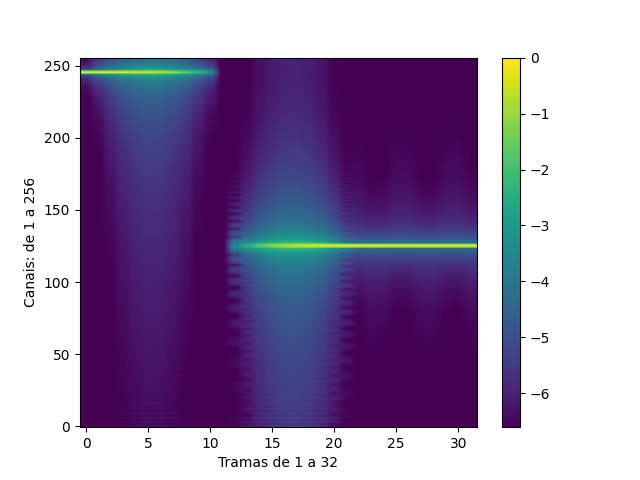

In [27]:
#<tf.Tensor: shape=(1, 256, 32, 1), dtype=float32, numpy=...>
Y_reshaped = tf.squeeze(Y, axis=(0, 3))  # Remove-se os eixos do Batch e Canal. (B,F,T,C) -> (F,T)
plt.figure(1)
plt.imshow(Y_reshaped, aspect='auto', origin='lower')
plt.colorbar()
#plt.title('CQT Spectrogram')
plt.xlabel('Tramas de 1 a 32')
plt.ylabel('Canais: de 1 a 256')

In [28]:
Nfpo=60

f256 = 440*2.**(38/12) # Si7 = 3951.066410048992 Hz;
f0=f256/2**(256/Nfpo) # fmin, 205.2672581380976 Hz
fmax = f0*2**(257/Nfpo) # fmax, 3996.975590329487 Hz

i=np.arange(1,256+1, dtype=float)
#k=np.arange(n_fft//2+1)
#f=k*sample_rate/n_fft

fcf = f0 * 2.**(i/Nfpo) #3905.68454168

fi = np.concatenate(([f0], fcf, [fmax])) #fi =[f0, fcf, fmax] 

In [29]:
# Dados
tramas = np.arange(0, 32)
diff_fc = np.diff(np.concatenate((fcf, [4000])))
#f_centrais = fcf - np.diff(np.concatenate(([fi[0]], fi, [4000]))) // 2
fc2 = fcf - diff_fc / 2

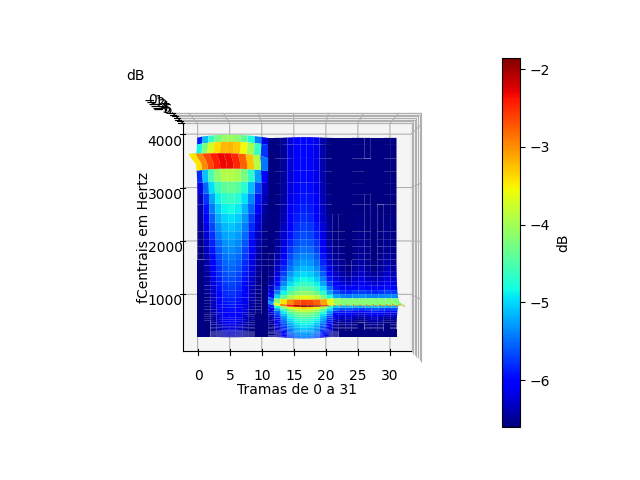

In [30]:
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(tramas, fc2)
surf = ax.plot_surface(X, Y, Y_reshaped, cmap='jet', edgecolor='none')
fig.colorbar(surf, label='dB')

# Configurações de visualização
ax.view_init(90, -90)
ax.set_xlabel('Tramas de 0 a 31')
ax.set_ylabel('fCentrais em Hertz')
ax.set_zlabel('dB')

plt.show()

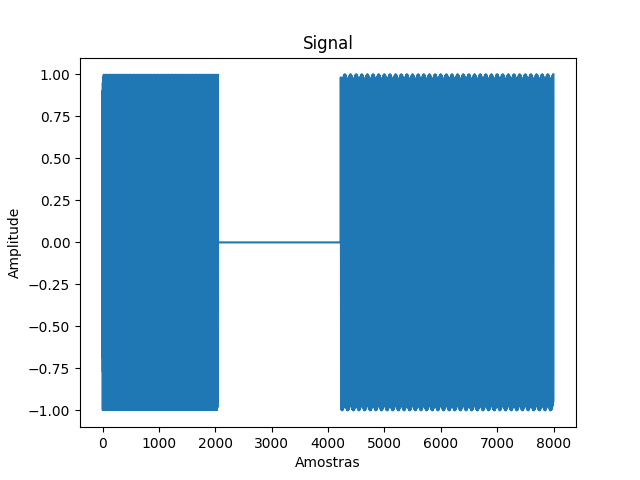

In [31]:
plt.figure(3)
plt.plot(np.arange(Nx), x)
plt.title('Signal')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

Dados

In [34]:
train_ds = dataset.get_train_ds(0)
enq = tf.keras.utils.OrderedEnqueuer(
        train_ds, use_multiprocessing=True, shuffle=train_ds.shuffle)
enq.start(workers=cfg['DEVICE']['CPU_N_WORKERS'],
        max_queue_size=cfg['DEVICE']['CPU_MAX_QUEUE'])

In [ ]:
X = next(enq.get())

In [ ]:
n_anchors = len(X[0])
X = tf.concat(X, axis=0)

In [ ]:
X

<tf.Tensor: shape=(120, 1, 8000), dtype=float32, numpy=
array([[[ 0.02230835,  0.0222168 ,  0.01745605, ...,  0.15991211,
          0.10513306,  0.02529907]],

       [[ 0.08618164,  0.08181763,  0.03396606, ...,  0.04492188,
          0.16067505,  0.20755005]],

       [[ 0.03540039, -0.06237793, -0.20309448, ...,  0.02456665,
          0.04943848, -0.02914429]],

       ...,

       [[-0.32580763, -0.10892136,  0.00721841, ..., -0.03701582,
         -0.08671004, -0.23245725]],

       [[-0.2333479 , -0.25759962, -0.2745687 , ..., -0.18148918,
          0.04591318, -0.07055764]],

       [[-0.10351632, -0.09949724,  0.1917368 , ..., -0.08730295,
          0.11898545,  0.48254055]]], dtype=float32)>

teste - a ver se funciona

In [ ]:
m_pre(X)

x=(<tf.Tensor 'add:0' shape=(None, 1, 32, 256) dtype=float32>, <class 'tensorflow.python.framework.ops.SymbolicTensor'>, TensorShape([None, 1, 32, 256]))
maximo=Tensor("Maximum:0", shape=(None, 1, 32, 256), dtype=float32)
x_contas=Tensor("truediv:0", shape=(None, 1, 32, 256), dtype=float32)
x do log=Tensor("truediv_1:0", shape=(None, 1, 32, 256), dtype=float32)


<tf.Tensor: shape=(120, 256, 32, 1), dtype=float32, numpy=
array([[[[-2.1570141],
         [-2.090388 ],
         [-1.9951849],
         ...,
         [-1.8442683],
         [-1.8309445],
         [-1.7389671]],

        [[-2.5577407],
         [-2.49413  ],
         [-2.3647828],
         ...,
         [-2.0541778],
         [-2.023367 ],
         [-1.8971535]],

        [[-2.6699297],
         [-2.641323 ],
         [-2.5222058],
         ...,
         [-2.1482785],
         [-2.1078653],
         [-2.0045207]],

        ...,

        [[-2.5266554],
         [-2.534115 ],
         [-2.4788697],
         ...,
         [-2.5620317],
         [-2.6111646],
         [-2.5709622]],

        [[-3.0734668],
         [-3.0857155],
         [-2.932283 ],
         ...,
         [-3.176679 ],
         [-3.2511086],
         [-2.9939563]],

        [[-3.2877324],
         [-3.1690273],
         [-3.0050046],
         ...,
         [-3.501768 ],
         [-3.5848567],
         [-3.0157619]]],


 

In [ ]:
#Passo seguinte, alterar o data augmentation antes de treinar.
feat = m_specaug(m_pre(X)) 

In [19]:
import os
import csv

folder_path = './DadosDebugMostrarProfessor'
file_name = 'X_antes_concat_trainStep.csv'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)


with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for array in X:
        writer.writerow(array)

print('Feito')

Feito


DataAug

In [1]:
from model.fp.specaug_chain.specaug_chain import get_specaug_chain_layer
from model.fp.specaug_chain.specaug_chain import display_spec
from model.fp.specaug_chain.specaug_chain import plot_to_image
from model.fp.specaug_chain.specaug_chain import test_chain

2024-05-27 22:48:54.280872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
get_specaug_chain_layer(cfg, trainable=False).chain_config

ListWrapper(['cutout', 'horizontal'])

Model: "m_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_mel (InputLayer)      [(64, 128, 96, 1)]        0         
                                                                 
 spec_aug_chainer_3 (SpecAu  (64, 128, 96, 1)          0         
 gChainer)                                                       
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


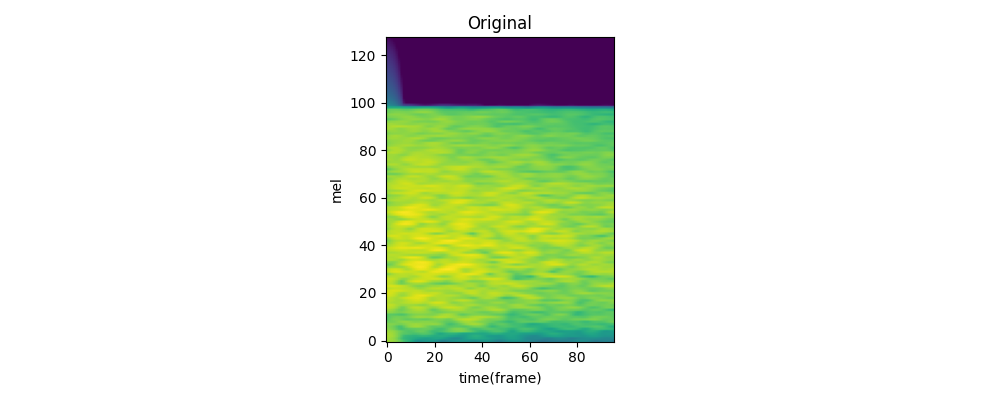

2024-05-27 22:49:11.886959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: sequential_275/spec_n_cutout_8/StatefulPartitionedCall/cond/branch_executed/_185


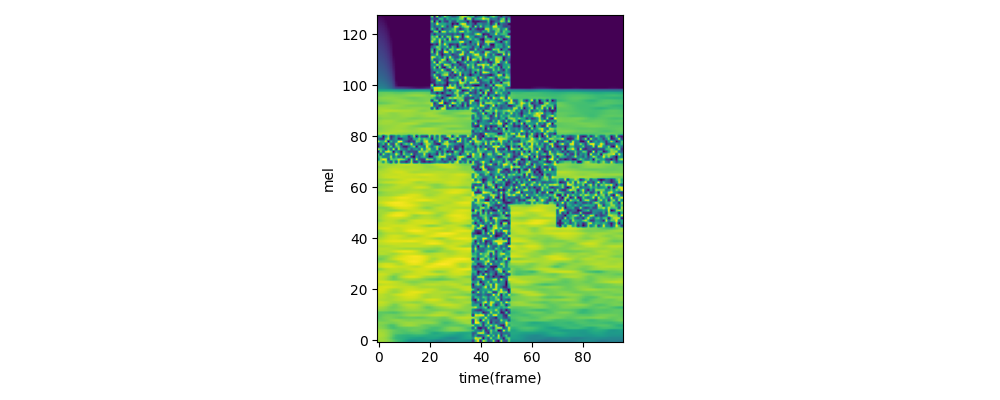

In [33]:
test_chain()